In [1]:
import json
import numpy as np
import cs_vqe.circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
import utils.bit_tools as bit
import utils.cs_vqe_tools_original as cs_tools
from qat.lang.AQASM import Program, X, H, S, CNOT, RZ
from qat.core.variables import Variable
from qat.core import Observable, Term
from matplotlib import pyplot as plt
from qat.plugins import ScipyMinimizePlugin
from qat.qpus import Stabs, LinAlg, MPS, Feynman
import random

Package not installed


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'H3+_STO-3G_SINGLET_alt', 'HeH+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET_alt', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET_alt', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'N+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET', 'NH_STO-3G_SINGLET', 'F+_STO-3G_SINGLET', 'Li+_STO-3G_SINGLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2+_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET'])

In [3]:
speciesname = "LiH_STO-3G_SINGLET"
molecule    = model_data[speciesname]

ham         = molecule['ham']
uccsd       = molecule['uccsd']
hf_config   = molecule['hf_config']
num_qubits  = molecule['num_qubits']
terms_noncon= molecule['terms_noncon']
#num_tapered = molecule['num_tapered']

In [4]:
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
#mol_circ.plot_cs_vqe_errors()

LiH_STO-3G_SINGLET reaches chemical accuracy for 4-qubit CS-VQE


In [5]:
gate_dict = {'X':X,'H':H,'S':S,'SDG':S.dag(),'RZ':RZ,'CX':CNOT}
theta0 = mol_circ.init_param
linalg_qpu = LinAlg(use_GPU=False)
optimizer_scipy = ScipyMinimizePlugin(method="COBYLA",
                                      tol=1e-3,
                                      options={"maxiter": 2500})

qpu = optimizer_scipy | linalg_qpu

for i in range(100):
    #anz_ops = ['YXIIXXII', 'YYIIZZYX', 'IYIIZXII', 'YYIIIIYX', 'XZIIZZYI'] + 
    anz_ops = ['XXIIIIXY', 'IYIIZZZX', 'ZIYZZIZI', 'IIIIYXYY', 'IXZZYZYI'] + random.choices(list(uccsd.keys()), k=3)
    print(anz_ops)
    anz = {op:uccsd[op] for op in anz_ops}
    ham_dict, num_sim_q, num_params, instructions = mol_circ.qlm_circuit(anz, num_sim_q).values()
    pauli_terms = [Term(coeff, op, list(range(num_sim_q))) for op, coeff in ham_dict.items()]
    hamiltonian = Observable(num_sim_q,pauli_terms=pauli_terms)
    
    prog = Program()
    qbits_reg = prog.qalloc(num_sim_q)
    params = [prog.new_var(float, "\\P{}".format(i)) for i in range(num_params)]

    for gate, var_num, q_pos in instructions:
        q_pos = [num_sim_q-p-1 for p in q_pos] #qubit ordering is reversed compared with Qiskit
        if gate == 'RZ':
            prog.apply(RZ(params[var_num[0]]), qbits_reg[q_pos[0]])
        elif gate == 'CX':
            prog.apply(CNOT, qbits_reg[q_pos[0]], qbits_reg[q_pos[1]])
        else:
            prog.apply(gate_dict[gate], qbits_reg[q_pos[0]])

    qc = prog.to_circ()
    job = qc.to_job(job_type="OBS", observable=hamiltonian)

    result = qpu.submit(job)
    error = result.value-mol_circ.truegs
    if error<0.0016:
        nfev = len(eval(result.meta_data['optimization_trace']))
        energy=eval(result.meta_data['optimization_trace'])

        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot([np.log10(abs(e-mol_circ.truegs)) for e in energy], label='CS-VQE convergence', color = "black")
        ax.hlines(np.log10(0.0016), 0, nfev, color='green', label='Chemical accuracy', ls='--')
        ax.hlines(np.log10(mol_circ.noncon-mol_circ.truegs), 0, nfev, color='red', label='Noncontextual ground state energy', ls='--')
        #plt.hlines(true_gs+0.0016, 0, nfev, color='pink')
        ax.set_title('{}: {}-qubit CS-VQE simulation'.format(speciesname, num_sim_q))
        ax.set_xlabel("Optimization count")
        ax.set_ylabel("Logarithmic error [log(Ha)]")
        ax.legend()
        
        break
        
    print("Minimum energy =", result.value, '| error =', error, '| Chemical accuracy?', error<0.0016)
    print("Optimal angles =", result.meta_data["parameters"])

['XXIIIIXY', 'IYIIZZZX', 'ZIYZZIZI', 'IIIIYXYY', 'IXZZYZYI', 'IYZZZXIX', 'IIIIYZXI', 'ZZZIXYZZ']
Minimum energy = -7.86315866399358 | error = 0.019603566978441123 | Chemical accuracy? False
Optimal angles = [-1.5975347228195032, -0.0017732296773913029, 3.142965517286732, 0.0012906093388923424, 0.007065325585700671, 0.0027480279399316027]
['XXIIIIXY', 'IYIIZZZX', 'ZIYZZIZI', 'IIIIYXYY', 'IXZZYZYI', 'IYIIYIYZ', 'ZXIZIYZX', 'IXZZYZYI']
Minimum energy = -7.87724228618896 | error = 0.00551994478306117 | Chemical accuracy? False
Optimal angles = [0.11206133724026617, -0.00444864302761019, 0.002432810386549398, 0.011799248180631756]
['XXIIIIXY', 'IYIIZZZX', 'ZIYZZIZI', 'IIIIYXYY', 'IXZZYZYI', 'ZZIIZXII', 'IIYIIIXX', 'XIZZZYIX']
Minimum energy = -7.877241956515188 | error = 0.005520274456833896 | Chemical accuracy? False
Optimal angles = [0.11221891889287716, -0.005127863959968563, 0.0010605414364005703, 0.011797866152397281]
['XXIIIIXY', 'IYIIZZZX', 'ZIYZZIZI', 'IIIIYXYY', 'IXZZYZYI', 'XZIIZZ

FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/home/di46kaq/qc-research/CS-VQE']

Exact ground state energy:  -14.403655108067708
[(0.33333333333204324, '01001'), (0.33229656531957236, '01011'), (0.1666666666641409, '01100'), (0.1661189578993115, '01101'), (0.0009227361359955192, '11001')]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


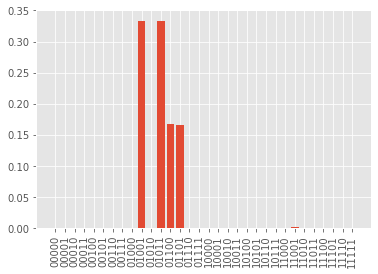

In [5]:
import numpy as np
from qat.dqs.hamiltonians import SpinHamiltonian

ham_rot = cs_tools.rotate_operator(mol_circ.ham_rotations, ham)
full_terms = [Term(coeff, op, list(range(num_qubits))) for op, coeff in ham_rot.items()]
ham_spin = SpinHamiltonian(nqbits=num_qubits, pauli_terms=full_terms)
ham_matrix = ham_spin.get_matrix()
eigvals, eigvecs = np.linalg.eigh(ham_matrix)
gs = sorted(list(zip(eigvals, eigvecs)), key=lambda x:x[0])[0]

print("Exact ground state energy: ", gs[0])
basis_states = [bit.int_to_bin(i, num_qubits) for i in range(2**num_qubits)]
sig_states = sorted(list(zip(abs(gs[1])**2, basis_states)), key=lambda x:-x[0])
print(sig_states[:5])

fig, ax = plt.subplots()
l1=ax.bar(basis_states, [abs(a)**2 for a in gs[1]])
l2=ax.set_xticklabels(basis_states, rotation=90)

In [6]:
nonconstate = mol_circ.reference_state()
print(nonconstate)
reverse_rot = []
for angle, rot in mol_circ.ham_rotations[::-1]:
    if angle == 'pi/2':
        reverse_rot.append([-np.pi/2, rot])
    else:
        reverse_rot.append([-angle, rot])

anz={}
for amp, state in sig_states[:2]:
    differs=[index for index, b in enumerate(state) if nonconstate[index]!=b]
    #pot_ops=[]
    #for op in uccsd.keys():
    #    diff_bits = {op[i] for i in differs}
    #    same_bits = {op[i] for i in range(num_qubits) if i not in differs}
    #    if diff_bits in [{'X'}, {'Y'}, {'X', 'Y'}] and same_bits in [{'I'},{'Z'},{'I', 'Z'}]:
    #        pot_ops.append(op)
    blank_op = ['I' for i in range(num_qubits)]
    for i in differs:
        blank_op[i] = 'X'
    op = ''.join(blank_op)
    if set(op)!={'I'}:
        anz[op] = amp

out_anz = cs_tools.rotate_operator(reverse_rot, anz)
out_anz

01011


{'IIIXI': -0.23868905930642, 'ZIIYI': -0.23267712409617614}

In [80]:
import random

#anz_ops = ['ZYXZI', 'YIIYX']#for C
#anz_ops = ['XIIYX', 'IYZYY'] #for B+
anz_ops = random.choices(list(uccsd.keys()), k=5)
#print(anz_ops)
anz = {op:uccsd[op] for op in anz_ops}
#anz=uccsd
ham_dict, num_sim_q, num_params, instructions = mol_circ.qlm_circuit(anz, num_sim_q).values()

In [81]:
anz_ops

['IIXXY', 'ZZYYY', 'ZYZIZ', 'IYIIZ', 'ZXIII']

In [82]:
cs_tools.rotate_operator(mol_circ.ham_rotations, anz)

{'IYIXX': 1.3873153572284228e-07,
 'IXIIX': 0.03525800009116136,
 'IYIZX': 0.034369945930894166,
 'XYZII': 8.326428663729759e-10,
 'XXZXI': 0.0002116124650788359,
 'YXIII': -3.332865768781443e-27,
 'YYIXI': 8.470329472477433e-22,
 'XXZIZ': -3.332865768781443e-27,
 'XYZXZ': 8.470329472477433e-22}

In [83]:
mol_dict = mol_circ.qlm_circuit(anz, num_sim_q)

In [84]:
#data={}
#for k in mol_dict.keys():
#    data[str(k)] = mol_dict[k]
    
#with open("data/QLM_circuits/"+speciesname+"_UCCSD_CS-VQE_circuit.json", "w") as outfile: 
#    json.dump(data, outfile)

In [85]:
pauli_terms = [Term(coeff, op, list(range(num_sim_q))) for op, coeff in ham_dict.items()]
hamiltonian = Observable(num_sim_q,
               pauli_terms=pauli_terms)
print("Hamiltonian:", hamiltonian)

Hamiltonian: -12.488598009446665 * I^3 +
-0.8582942466478601 * (ZZ|[0, 2]) +
-0.8582942466478596 * (ZZZ|[0, 1, 2]) +
0.02304317581163877 * (Z|[1]) +
0.8582942466478598 * (ZZ|[1, 2]) +
-0.023043175811635994 * (ZZ|[0, 1]) +
-0.02304317581163723 * (Z|[0]) +
-0.6424707457533954 * (Z|[2]) +
-0.0013878749793264473 * (XZ|[0, 1]) +
-0.012044994860721135 * (YZ|[0, 1]) +
0.0013878749793264473 * (X|[0]) +
0.012044994860721135 * (Y|[0]) +
0.0013878749793264473 * (YYZ|[0, 1, 2]) +
-0.012044994860721135 * (XYZ|[0, 1, 2]) +
-0.012044994860721135 * (YXZ|[0, 1, 2]) +
-0.0013878749793264473 * (XXZ|[0, 1, 2]) +
-0.012124689610585465 * (ZXZ|[0, 1, 2]) +
-0.012124689610585465 * (XZ|[1, 2]) +
-0.04340448812180735 * (ZYX|[0, 1, 2]) +
0.04340448812180735 * (YX|[1, 2]) +
0.043119193389137625 * (XXX|[0, 1, 2]) +
0.043119193389137625 * (YYX|[0, 1, 2]) +
0.043119193389137625 * (YY|[0, 2]) +
0.043119193389137625 * (YZY|[0, 1, 2]) +
-0.004968375044847624 * (YXX|[0, 1, 2]) +
0.004968375044847624 * (XYX|[0, 1, 2]) +


In [86]:
gate_dict = {'X':X,'H':H,'S':S,'SDG':S.dag(),'RZ':RZ,'CX':CNOT}
prog = Program()
qbits_reg = prog.qalloc(num_sim_q)
params = [prog.new_var(float, "\\P{}".format(i)) for i in range(num_params)]

for gate, var_num, q_pos in instructions:
    q_pos = [num_sim_q-p-1 for p in q_pos] #qubit ordering is reversed compared with Qiskit
    if gate == 'RZ':
        prog.apply(RZ(params[var_num[0]]), qbits_reg[q_pos[0]])
    elif gate == 'CX':
        prog.apply(CNOT, qbits_reg[q_pos[0]], qbits_reg[q_pos[1]])
    else:
        prog.apply(gate_dict[gate], qbits_reg[q_pos[0]])

qc = prog.to_circ()

In [87]:

#from qat.plugins import SPSAMinimizePlugin
#from qat.plugins import PSOMinimizePlugin

theta0 = mol_circ.init_param
linalg_qpu = LinAlg(use_GPU=False)

#optimizer_pso = PSOMinimizePlugin(theta0, max_iter=50, swarm_number=10)
#optimizer_spsa = SPSAMinimizePlugin(theta0)
optimizer_scipy = ScipyMinimizePlugin(method="COBYLA",
                                      tol=1e-3,
                                      options={"maxiter": 2000})

qpu = optimizer_scipy | linalg_qpu

job = qc.to_job(job_type="OBS", observable=hamiltonian)

result = qpu.submit(job)

print("Minimum energy =", result.value, "... chemacc?", result.value-mol_circ.truegs<0.0016)
print("Optimal angles =", result.meta_data["parameters"])

Minimum energy = -14.372790082541965 ... chemacc? False
Optimal angles = [1.8418151282616417, 2.511573292072408]


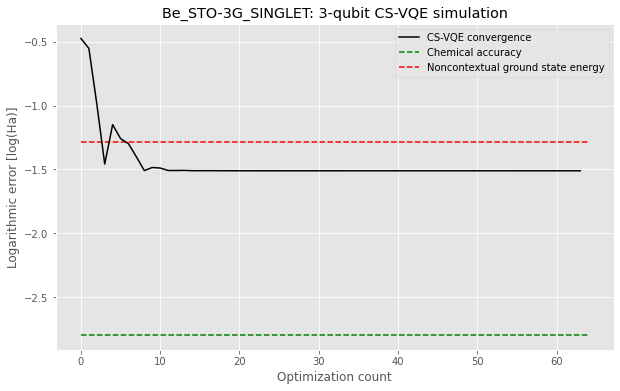

In [88]:
nfev = len(eval(result.meta_data['optimization_trace']))
energy=eval(result.meta_data['optimization_trace'])

fig, ax = plt.subplots(figsize=(10,6))
ax.plot([np.log10(abs(e-mol_circ.truegs)) for e in energy], label='CS-VQE convergence', color = "black")
ax.hlines(np.log10(0.0016), 0, nfev, color='green', label='Chemical accuracy', ls='--')
ax.hlines(np.log10(mol_circ.noncon-mol_circ.truegs), 0, nfev, color='red', label='Noncontextual ground state energy', ls='--')
#plt.hlines(true_gs+0.0016, 0, nfev, color='pink')
ax.set_title('{}: {}-qubit CS-VQE simulation'.format(speciesname, num_sim_q))
ax.set_xlabel("Optimization count")
ax.set_ylabel("Logarithmic error [log(Ha)]")
ax.legend()

In [25]:
#fig.savefig('plots/'+speciesname+'_CS-VQE_test.png', dpi=300, bbox_inches='tight')

['IYIIZ', 'IYIZI', 'XIZII', 'ZXIXY', 'ZZYZZ']


FileNotFoundError: [Errno 2] No usable temporary directory found in ['/tmp', '/var/tmp', '/usr/tmp', '/home/di46kaq/qc-research/CS-VQE']

In [29]:
#data={}
#for k in result.meta_data.keys():
#    data[str(k)] = result.meta_data[k]
#    
#with open("data/QLM_circuits/"+speciesname+"_CS-VQE_test.json", "w") as outfile: 
#    json.dump(data, outfile)